In [1]:
import matplotlib.pyplot as plt
import argparse
import time
import numpy as np
import mne
import samplerate
import os
from scipy import signal

import spkit as sp

import seaborn as sns
#from brainflow #import BrainFlow

from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds, BrainFlowPresets

In [2]:
import pandas as pd
from scipy import signal
import numpy as np

def estimate_snr(signal, fs, signal_band=(1,20), noise_band=(0.5, 40)):
    f, Pxx = welch(signal, fs, nperseg=fs*2)
    signal_power = np.sum(Pxx[(f >= signal_band[0]) & (f <= signal_band[1])])
    total_power = np.sum(Pxx[(f >= noise_band[0]) & (f <= noise_band[1])])
    noise_power = total_power - signal_power
    return 10 * np.log10(signal_power / (noise_power + 1e-10))



def filtering(data, samp_freq):
    notch_freq = 50.0
    quality_factor = 30.0 


    b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, samp_freq)

    
    sos = signal.butter(3, [1, 70], btype='bandpass', fs=samp_freq, output='sos')


    data_filtered = np.copy(data)


    for ii in range(data.shape[0]):
     
        data_filtered[ii, :] = signal.filtfilt(b_notch, a_notch, data_filtered[ii, :])
      
        data_filtered[ii, :] = signal.sosfilt(sos, data_filtered[ii, :])

    return data_filtered


def plot_fft(data, fs, canal=0):
    from scipy.fft import fft, fftfreq

    señal = data[canal]
    n = len(señal)
    freqs = fftfreq(n, d=1/fs)
    magnitud = np.abs(fft(señal))[:n//2]
    freqs = freqs[:n//2]

    plt.figure(figsize=(10, 4))
    plt.plot(freqs, magnitud, color='darkgreen')
    plt.title(f'psd - channel {canal}')
    plt.xlabel('Freq (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim(0, 60)  # para ver hasta 60 Hz
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [118]:
data2=pd.read_csv('/Users/laura/Documents/MUSE/HOLS/13mai-cable28AWG-sitting.csv',delimiter=',',header=None)
data1=pd.read_csv('/Users/laura/Documents/MUSE/HOLS/13mai-cable28AWG-moving.csv',delimiter=',',header=None)
data3=pd.read_csv('/Users/laura/Documents/MUSE/HOLS/13mai-cable28AWG-dribnking.csv',delimiter=',',header=None)
data4=pd.read_csv('/Users/laura/Documents/MUSE/HOLS/13mai-cable28AWG-chewing.csv',delimiter=',',header=None)

data5=pd.read_csv('/Users/laura/Documents/MUSE/TESTS-NEOXA2/2maiheadbandpassive-eyesclosed.csv',delimiter=',',header=None)


In [3]:
eo1=pd.read_csv('/Users/laura/Documents/MUSE/HOLS/Eyesopen-Trial1.csv',delimiter=',',header=None)
eo2=pd.read_csv('/Users/laura/Documents/MUSE/HOLS/Eyesopen-Trial2.csv',delimiter=',',header=None)
eo3=pd.read_csv('/Users/laura/Documents/MUSE/HOLS/Eyesopen-Trial3.csv',delimiter=',',header=None)
ec1=pd.read_csv('/Users/laura/Documents/MUSE/HOLS/Eyesclosed-Trial1.csv',delimiter=',',header=None)
ec2=pd.read_csv('/Users/laura/Documents/MUSE/HOLS/Eyesclosed-Trial2.csv',delimiter=',',header=None)
ec3=pd.read_csv('/Users/laura/Documents/MUSE/HOLS/Eyesclosed-Trial3.csv',delimiter=',',header=None)

In [4]:
samp_freq = 250 
data_filtered = filtering(data3, samp_freq) 
n_samples_to_cut = 3 * samp_freq

data_filtered_cut = data_filtered[:, n_samples_to_cut:]
#times_cut = times[n_samples_to_cut:]
XR_M = sp.eeg.ATAR(data_filtered_cut.copy(),wv='db4', winsize=5*250 , beta=0.1,thr_method=None,theta_a=20,OptMode='elim', verbose=0)

/opt/anaconda3/envs/EMOTION/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
/opt/anaconda3/envs/EMOTION/lib/python3.12/ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead


NameError: name 'data3' is not defined

In [225]:
filt3=XR_M[3,:]

In [6]:
def process(data, samp_freq=250, cut_samp=3, winsize_sec=5, 
                               wavelet='db4', beta=0.1, thr_method=None, 
                               theta_a=20, OptMode='elim', verbose=0):
    def filtering(data, samp_freq):
        notch_freq = 50.0
        quality_factor = 30.0 
    
        b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, samp_freq)
        sos = signal.butter(3, [1, 70], btype='bandpass', fs=samp_freq, output='sos')
    
        data_filtered = np.copy(data)
    
        for ii in range(data.shape[0]):
            # Filtros de fase cero
            data_filtered[ii, :] = signal.filtfilt(b_notch, a_notch, data_filtered[ii, :])
            data_filtered[ii, :] = signal.sosfiltfilt(sos, data_filtered[ii, :])
    
        return data_filtered
    
    data_filt = filtering(data, samp_freq)


    cut= cut_samp * samp_freq
    filt_cut = data_filt[:, cut:]


    resultado_ATAR = sp.eeg.ATAR(
        filt_cut.copy(),
        wv=wavelet,
        winsize=winsize_sec * samp_freq,
        beta=beta,
        thr_method=thr_method,
        theta_a=theta_a,
        OptMode=OptMode,
        verbose=verbose
    )

    return resultado_ATAR


In [9]:
eo1_filt=process(eo1)
eo2_filt=process(eo2)
eo3_filt=process(eo3)
ec1_filt=process(ec1)
ec2_filt=process(ec2)
ec3_filt=process(ec3)

/opt/anaconda3/lib/python3.12/site-packages/spkit/eeg/atar_algorithm.py:507: UserWarning: Make sure the upper and lower bound values (k1,k2) are of same order as signal amplitude. If amplitude of signal is much lower than k2 or even k1, ATAR algorithm will have no affect on signal. For example, k2=100, and/or k1=10 is setting for amplitude in micro-volt (in order of 100s). If provided signal is in volt (1e-6), multiply signal with 1e6 (X*1e6) and then apply ATAR
/opt/anaconda3/lib/python3.12/site-packages/spkit/eeg/atar_algorithm.py:510: UserWarning: Upper bound k2 is set to very high. ATAR might have no impact of signal. Either change amplitude unit of signal by multiplying 1e3, or 1e6, or lower the value of k2 and respectively, k1.  One of the straightforward way to set k2 is k2 = np.std(X).


In [10]:
def plot_psd(processed, electrode_names=['Fp1', 'Fp2'], fs=250, win_sec=5):

    sns.set(font_scale=1.0, style='whitegrid')
    fig, axes = plt.subplots(3, 2, figsize=(12, 9), sharex=True, sharey=True)
    win = win_sec * fs
    
    for i, data in enumerate(processed):
        for j, (electrode_idx, name) in enumerate(zip([1, 2], electrode_names)):
            signal_data = data[electrode_idx, :]
            freqs, psd = signal.welch(signal_data, fs, nperseg=win)

            ax = axes[i, j]
            ax.plot(freqs, psd, color='b', lw=1.5)
            ax.set_title(f"Recording {i+1} - {name}")
            ax.set_xlim(0, 60)
            ax.set_ylim(0, psd.max() * 1.1)
            if i == 2:
                ax.set_xlabel('Freq(Hz)')
            if j == 0:
                ax.set_ylabel('PSD (V²/Hz)')
    
    plt.tight_layout()
    plt.suptitle("PSD Fp1  Fp2 (3 recordings)", y=1.02, fontsize=16)
    plt.show()

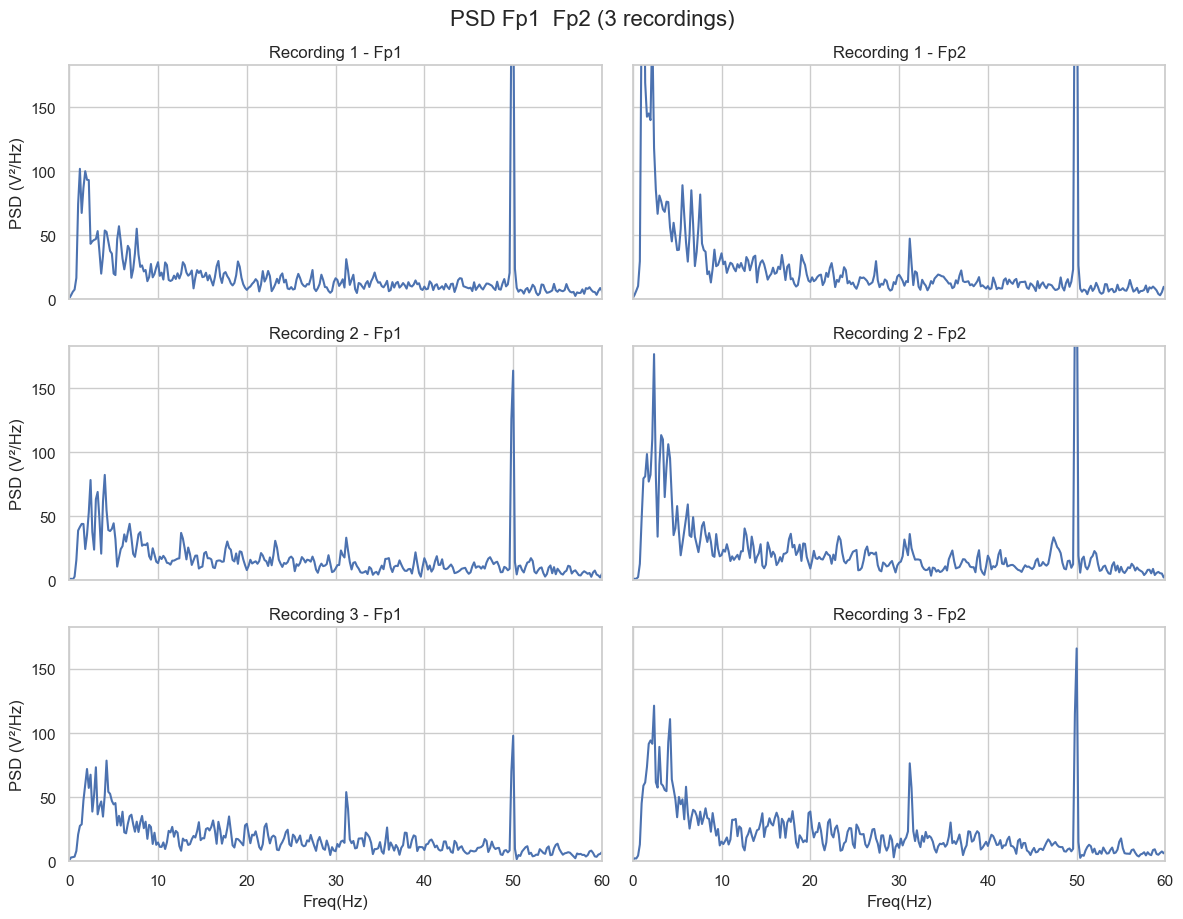

In [8]:
filtered = [eo1_filt, eo2_filt, eo3_filt]  # Cada uno es (2 x tiempo), Fp1=0, Fp2=1

plot_psd(filtered)

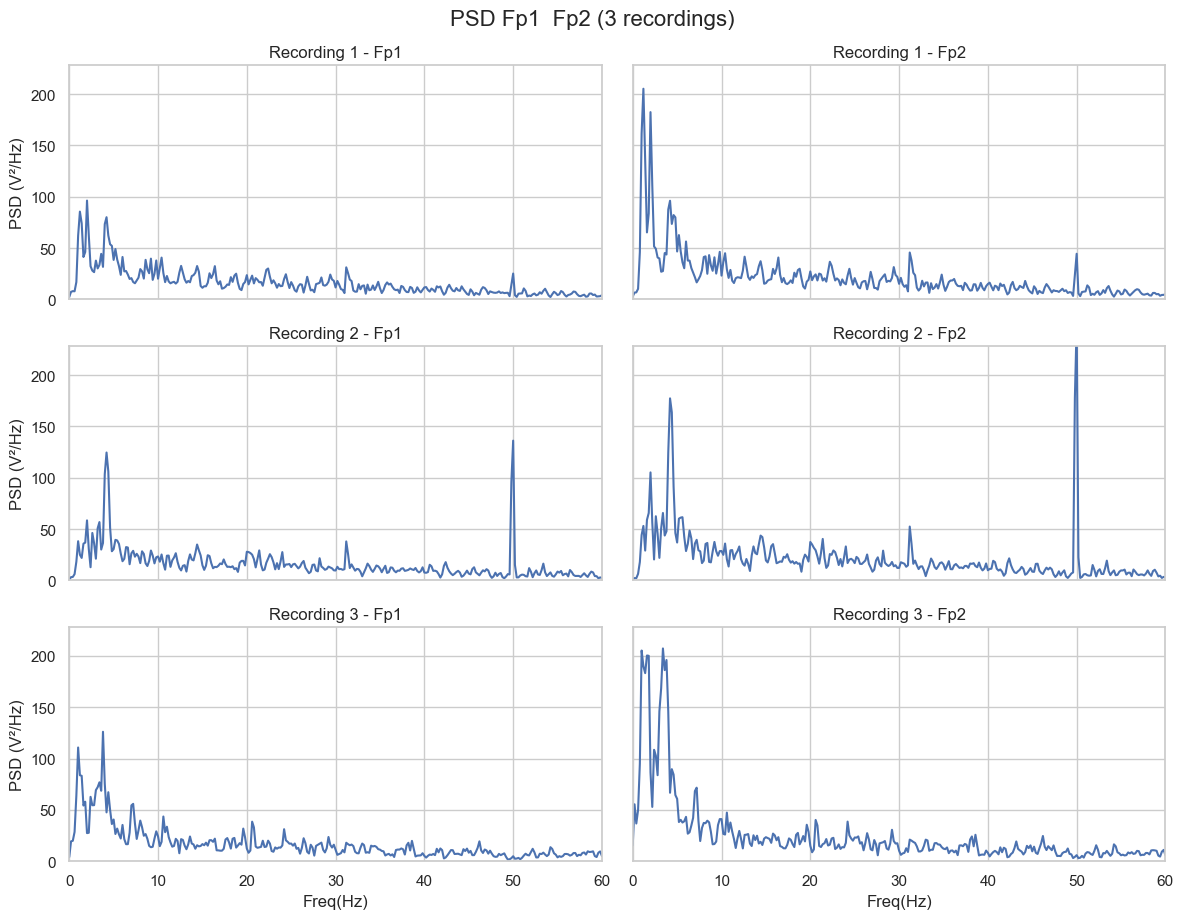

In [10]:
filtered = [ec1_filt, ec2_filt, ec3_filt]  # Cada uno es (2 x tiempo), Fp1=0, Fp2=1

plot_psd(filtered)

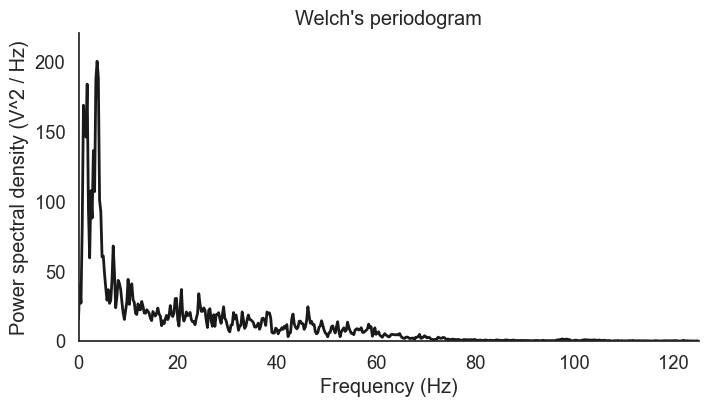

In [279]:
from scipy import signal
import seaborn as sns
fs=250
data=ec3_filt[2,:]
# Define window length (4 seconds)


win = 4 * fs
freqs, psd = signal.welch(data, fs, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

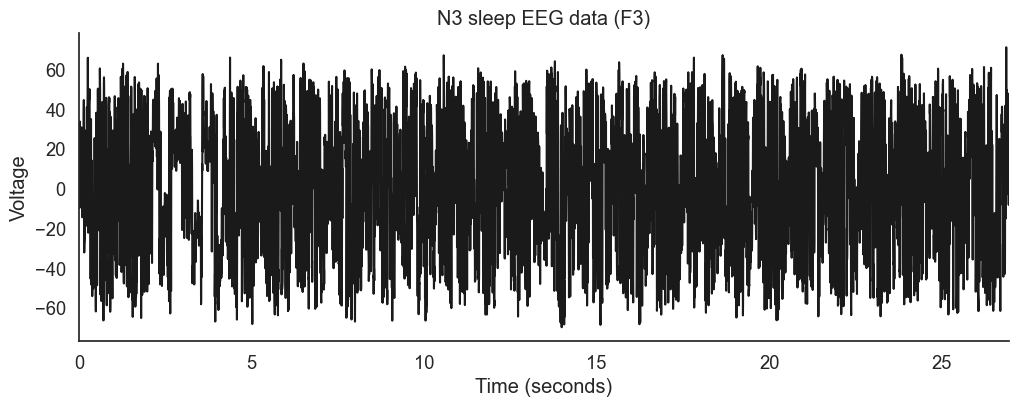

In [235]:
time = np.arange(data.size) / fs

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([time.min(), time.max()])
plt.title('N3 sleep EEG data (F3)')
sns.despine()

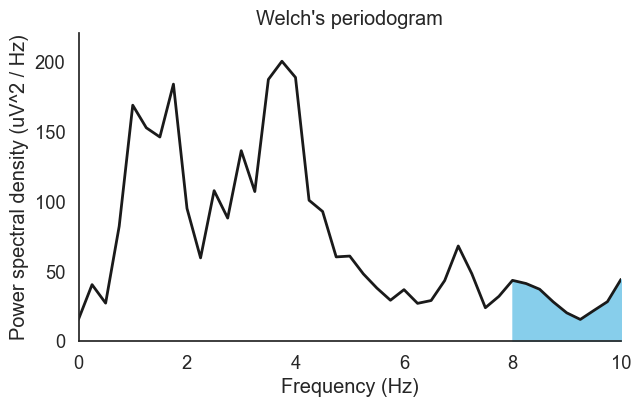

In [281]:

low, high = 8, 12

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 10])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

In [215]:
from scipy.integrate import simps

# Frequency resolution
freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve
alpha_power = simps(psd[idx_delta], dx=freq_res)
print('Absolute delta power: %.3f uV^2' % alpha_power)

Absolute delta power: 80.474 uV^2


/var/folders/1m/2gsg5r5x3_xb8rgnzdgz8_t00000gn/T/ipykernel_81021/832166662.py:7: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0


In [169]:
total_power = simps(psd, dx=freq_res)
alpha_rel_power = alpha_power / total_power
print('Relative alpha power: %.3f' % alpha_rel_power)

Relative alpha power: 0.071


/var/folders/1m/2gsg5r5x3_xb8rgnzdgz8_t00000gn/T/ipykernel_81021/2446578583.py:1: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0


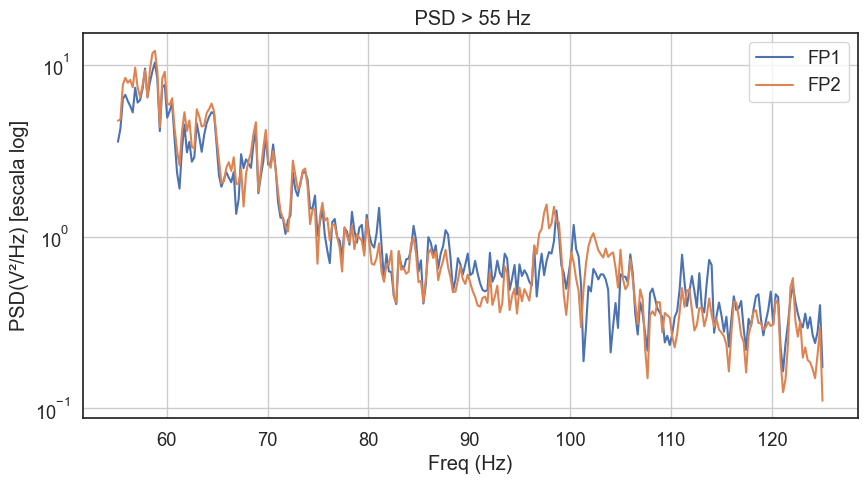

In [283]:


fs = 250  


datos = {
    'FP1': ec3_filt[1,:],
    'FP2': ec3_filt[2,:],
   
    # Agrega más señales si es necesario
}

plt.figure(figsize=(10, 5))

for nombre, data in datos.items():
    frequencies, psd = welch(data, fs=fs, nperseg=1024)
    mask = frequencies > 55
    frequencies_high = frequencies[mask]
    psd_high = psd[mask]
    
    plt.semilogy(frequencies_high, psd_high, label=nombre)

plt.title(' PSD > 55 Hz')
plt.xlabel('Freq (Hz)')
plt.ylabel('PSD(V²/Hz) [escala log]')
plt.grid(True)
plt.legend()
plt.show()


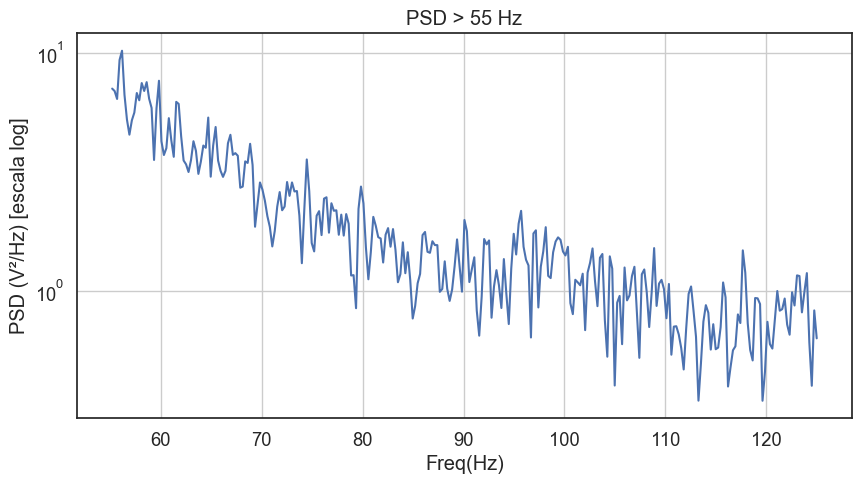

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch


fs = 250  # frecuencia de muestreo



frequencies, psd = welch(data, fs=fs, nperseg=1024)

# Filtrar para frecuencias mayores a 55 Hz
mask = frequencies > 55
frequencies_high = frequencies[mask]
psd_high = psd[mask]

# Graficar en escala logarítmica
plt.figure(figsize=(10, 5))
plt.semilogy(frequencies_high, psd_high)
plt.title('PSD > 55 Hz')
plt.xlabel('Freq(Hz)')
plt.ylabel('PSD (V²/Hz) [escala log]')
plt.grid(True)
plt.show()


In [287]:
import numpy as np
from scipy.signal import welch
from scipy.stats import iqr

def compute_band_power_ratios(signal, fs):
    # Calcular PSD con Welch
    freqs, psd = welch(signal, fs=fs, nperseg=fs*4)

    # Definir bandas
    bands = {
        'delta': (1, 3),
        'theta': (4, 7),
        'alpha': (8, 12),
        'beta': (13, 30),
        'noise': (55, np.max(freqs))  # banda de "ruido"
    }

    # Calcular potencia por banda
    band_powers = {}
    for band_name, (low, high) in bands.items():
        idx = np.logical_and(freqs >= low, freqs <= high)
        band_power = np.sum(psd[idx])
        band_powers[band_name] = band_power

    # Calcular ratios banda / ruido
    noise_power = band_powers['noise']
    ratios = {band: band_powers[band] / noise_power for band in ['delta', 'theta', 'alpha', 'beta']}

    return ratios


fs = 250  # frecuencia de muestreo en Hz

ratios = compute_band_power_ratios(ec3_filt[2,:], fs)

print(ratios)  


{'delta': 2.4685051995057354, 'theta': 1.7867484076253184, 'alpha': 1.1083464895242112, 'beta': 2.8366288539545965}


In [123]:
import numpy as np
from scipy.signal import welch
from scipy.integrate import simps

def eeg_quality_metrics(signal, fs, ref_channel=None):
    """
    Evaluates basic quality metrics of an EEG signal using absolute spectral power (uV^2).

    Parameters:
    - signal: EEG signal (1D array)
    - fs: Sampling frequency in Hz
    - ref_channel: Second channel to check left-right symmetry (optional)

    Returns:
    - Dictionary with quality metrics
    """

    duration = len(signal) / fs

    # Power Spectral Density using Welch method
    f, Pxx = welch(signal, fs, nperseg=fs*4)
    freq_res = f[1] - f[0]  # Frequency resolution

    # 1. Band powers using integration (absolute power in uV^2)
    def band_power(low, high):
        idx = np.logical_and(f >= low, f <= high)
        return simps(Pxx[idx], dx=freq_res)

    alpha_power = band_power(8, 12)
    delta_power = band_power(1, 3)
    beta_power = band_power(13, 30)

    # 2. Power at power line frequency (e.g., 50 Hz)
    noise_freq = 50
    noise_power = band_power(noise_freq - 1, noise_freq + 1)

    # 3. Zero crossings
    zero_crossings = ((signal[:-1] * signal[1:]) < 0).sum()
    zero_crossings_rate = zero_crossings / duration  # per second

    # 4. Flatline detection
    flat_threshold = 1e-6
    flat_samples = np.sum(np.abs(np.diff(signal)) < flat_threshold)
    flatline_ratio = flat_samples / len(signal)

    # 5. Large jump artifacts
    jump_threshold = 5 * np.std(signal)
    large_jumps = np.sum(np.abs(np.diff(signal)) > jump_threshold)

    # 6. Signal range
    signal_range = np.max(signal) - np.min(signal)

    # 7. Left-right symmetry
    symmetry_corr = None
    if ref_channel is not None:
        min_len = min(len(signal), len(ref_channel))
        symmetry_corr = np.corrcoef(signal[:min_len], ref_channel[:min_len])[0, 1]

    return {
        'alpha_power_uV2': alpha_power,
        'beta_power_uV2': beta_power,
        'delta_power_uV2': delta_power,
        'line_noise_power_uV2': noise_power,
        'zero_crossings_per_sec': zero_crossings_rate,
        'percentage_flatline': flatline_ratio * 100,
        'large_jumps': large_jumps,
        'range_uV': signal_range,
        'symmetry_corr_LR': symmetry_corr
    }


In [289]:
fp1=eeg_quality_metrics(ec3_filt[1,:], 250,ec3_filt[2,:])
fp2=eeg_quality_metrics(ec3_filt[2,:], 250,ec3_filt[1,:])


/var/folders/1m/2gsg5r5x3_xb8rgnzdgz8_t00000gn/T/ipykernel_81021/3719232723.py:27: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0


In [291]:
fp1

{'alpha_power_uV2': 93.95787424018539,
 'beta_power_uV2': 268.51191181603065,
 'delta_power_uV2': 115.13993315571156,
 'line_noise_power_uV2': 6.671694106134741,
 'zero_crossings_per_sec': 51.58199643493761,
 'percentage_flatline': 0.0,
 'large_jumps': 0,
 'range_uV': 182.96795673437083,
 'symmetry_corr_LR': 0.9085901904927783}

In [293]:
fp2


{'alpha_power_uV2': 117.5123943474753,
 'beta_power_uV2': 325.19855664707524,
 'delta_power_uV2': 245.5173174857619,
 'line_noise_power_uV2': 14.276031671816423,
 'zero_crossings_per_sec': 47.27421271538918,
 'percentage_flatline': 0.0,
 'large_jumps': 0,
 'range_uV': 191.35716972592047,
 'symmetry_corr_LR': 0.9085901904927784}

In [20]:
# stat EO

fp1EO = [
    {'delta': 1.2328245966276967, 'theta': 0.8598885517348224, 'alpha': 0.6612346807533896, 'beta': 1.8216936997841868},
    {'delta': 0.9755229093069282, 'theta': 1.0445293255230315, 'alpha': 0.7225529847411846, 'beta': 2.2546642631652194},
    {'delta': 0.9022061179241994, 'theta': 0.9891695769814548, 'alpha': 0.7071475076064468, 'beta': 2.5052144308651427}
]
fp2EO = [
    {'delta': 2.622152774538213, 'theta': 1.3529088958245938, 'alpha': 0.8798675944354596, 'beta': 2.3634700889876408},
    {'delta': 2.1323337702862752, 'theta': 1.4433429983197053, 'alpha': 0.9078763268222189, 'beta': 2.6826973965254663},
    {'delta': 1.6172750650401952, 'theta': 1.3114675087579606, 'alpha': 0.8696980148178305, 'beta': 3.096810385456438}
]
fp1EC = [
    {'delta': 1.2005789726772027, 'theta': 1.2655556744778524, 'alpha': 1.063702792496175, 'beta': 2.9267036803099953},
    {'delta': 0.6887075424031442, 'theta': 1.290931850800313, 'alpha': 0.785285466242677, 'beta': 2.5315296293589356},
    {'delta': 1.2667547209045036, 'theta': 1.3094507247993203, 'alpha': 0.9788340338825489, 'beta': 2.5567444014971006}
]

fp2EC = [
    {'delta': 1.9571361684365198, 'theta': 1.527146209811782, 'alpha': 1.2000139533678886, 'beta': 3.3332595993399283},
    {'delta': 1.0717842707778336, 'theta': 1.8926680257658834, 'alpha': 1.0035650609417404, 'beta': 3.2614230732044276},
    {'delta': 2.4685051995057354, 'theta': 1.7867484076253184, 'alpha': 1.1083464895242112, 'beta': 2.8366288539545965}
]
recording=fp1EC
df = pd.DataFrame(recording)


summary = pd.DataFrame({
    'mean': df.mean(),
    'IQR': df.quantile(0.75) - df.quantile(0.25)
})

formatted = summary.apply(lambda row: f"{row['mean']:.4f} ± {row['IQR']:.4f}", axis=1)
print(formatted)

delta    1.0520 ± 0.2890
theta    1.2886 ± 0.0219
alpha    0.9426 ± 0.1392
beta     2.6717 ± 0.1976
dtype: object


In [36]:
# METRICS
import pandas as pd

# Datos de las 3 condiciones
recordingsEOFP1 = [
    {
        'alpha_power_uV2': 86.96074239242836,
        'beta_power_uV2': 251.4803766878843,
        'delta_power_uV2': 159.03375002743027,
        'line_noise_power_uV2': 98.41613038730944,
        'zero_crossings_per_sec': 57.304038004750595,
        'percentage_flatline': 0.0,
        'large_jumps': 0,
        'range_uV': 186.6911782781535,
        'symmetry_corr_LR': 0.8600784682619796
    },
    {
        'alpha_power_uV2': 76.20300845598565,
        'beta_power_uV2': 255.4812725692296,
        'delta_power_uV2': 95.20698560466417,
        'line_noise_power_uV2': 63.21071861820434,
        'zero_crossings_per_sec': 57.2700296735905,
        'percentage_flatline': 0.0,
        'large_jumps': 0,
        'range_uV': 173.91972086546912,
        'symmetry_corr_LR': 0.8775689615018331
    },
    {
        'alpha_power_uV2': 80.47412008808158,
        'beta_power_uV2': 303.0582715669054,
        'delta_power_uV2': 97.69934887542202,
        'line_noise_power_uV2': 42.983107951834,
        'zero_crossings_per_sec': 58.25783454626467,
        'percentage_flatline': 0.0,
        'large_jumps': 0,
        'range_uV': 157.16706163822448,
        'symmetry_corr_LR': 0.9169353976670045
    }
]


df = pd.DataFrame(recordingsEOFP1)


mean_values = df.mean(numeric_only=True)


print(mean_values.round(2))


alpha_power_uV2            81.21
beta_power_uV2            270.01
delta_power_uV2           117.31
line_noise_power_uV2       68.20
zero_crossings_per_sec     57.61
percentage_flatline         0.00
large_jumps                 0.00
range_uV                  172.59
symmetry_corr_LR            0.88
dtype: float64


In [38]:
recordingsEOFP2 = [
        {'alpha_power_uV2': 109.84094286713527,
         'beta_power_uV2': 313.1901092077789,
         'delta_power_uV2': 325.909877668459,
         'line_noise_power_uV2': 125.59475691781392,
         'zero_crossings_per_sec': 55.819477434679335,
         'percentage_flatline': 0.0,
         'large_jumps': 0,
         'range_uV': 221.74598134864314,
         'symmetry_corr_LR': 0.8600784682619798}
        ,
        {'alpha_power_uV2': 97.38177457590787,
         'beta_power_uV2': 308.5681574593464,
         'delta_power_uV2': 219.20671502094166,
         'line_noise_power_uV2': 100.91696708374562,
         'zero_crossings_per_sec': 55.97181008902077,
         'percentage_flatline': 0.0,
         'large_jumps': 0,
         'range_uV': 222.1873004822329,
         'symmetry_corr_LR': 0.8775689615018331}
        ,
        {'alpha_power_uV2': 98.66242641578874,
         'beta_power_uV2': 374.5609506291501,
         'delta_power_uV2': 178.23782231494306,
         'line_noise_power_uV2': 66.07208486328332,
         'zero_crossings_per_sec': 55.80721817911778,
         'percentage_flatline': 0.0,
         'large_jumps': 0,
         'range_uV': 196.14216869813603,
         'symmetry_corr_LR': 0.9169353976670046}

]

df = pd.DataFrame(recordingsEOFP2)

# Calcular la media por métrica
mean_values = df.mean(numeric_only=True)

# Mostrar resultados redondeados a 2 decimales
print(mean_values.round(2))

alpha_power_uV2           101.96
beta_power_uV2            332.11
delta_power_uV2           241.12
line_noise_power_uV2       97.53
zero_crossings_per_sec     55.87
percentage_flatline         0.00
large_jumps                 0.00
range_uV                  213.36
symmetry_corr_LR            0.88
dtype: float64


In [42]:
recordingsECFP1 = [
        {'alpha_power_uV2': 107.5961831206613,
         'beta_power_uV2': 295.40228378702375,
         'delta_power_uV2': 112.41682300389607,
         'line_noise_power_uV2': 14.97341099017701,
         'zero_crossings_per_sec': 51.135520261243876,
         'percentage_flatline': 0.0,
         'large_jumps': 0,
         'range_uV': 141.0115860049683,
         'symmetry_corr_LR': 0.9589090100175088}

        ,
        {'alpha_power_uV2': 84.68336771389123,
         'beta_power_uV2': 285.14334810525963,
         'delta_power_uV2': 71.38482561400555,
         'line_noise_power_uV2': 50.404782850827644,
         'zero_crossings_per_sec': 58.04631828978623,
         'percentage_flatline': 0.0,
         'large_jumps': 0,
         'range_uV': 147.6947726823022,
         'symmetry_corr_LR': 0.9597943922023056}

        ,
       {'alpha_power_uV2': 93.95787424018539,
         'beta_power_uV2': 268.51191181603065,
         'delta_power_uV2': 115.13993315571156,
         'line_noise_power_uV2': 6.671694106134741,
         'zero_crossings_per_sec': 51.58199643493761,
         'percentage_flatline': 0.0,
         'large_jumps': 0,
         'range_uV': 182.96795673437083,
         'symmetry_corr_LR': 0.9085901904927783}]

df = pd.DataFrame(recordingsECFP1)

# Calcular la media por métrica
mean_values = df.mean(numeric_only=True)

# Mostrar resultados redondeados a 2 decimales
print(mean_values.round(2))



alpha_power_uV2            95.41
beta_power_uV2            283.02
delta_power_uV2            99.65
line_noise_power_uV2       24.02
zero_crossings_per_sec     53.59
percentage_flatline         0.00
large_jumps                 0.00
range_uV                  157.22
symmetry_corr_LR            0.94
dtype: float64


In [44]:
recordingsECFP2 = [
        {'alpha_power_uV2': 128.41681024660696,
         'beta_power_uV2': 358.7383074737281,
         'delta_power_uV2': 193.3645013202345,
         'line_noise_power_uV2': 21.062401874174537,
         'zero_crossings_per_sec': 51.469496808668545,
         'percentage_flatline': 0.0,
         'large_jumps': 0,
         'range_uV': 175.04940411149335,
         'symmetry_corr_LR': 0.9589090100175087}


        ,
        {'alpha_power_uV2': 110.82971963415841,
         'beta_power_uV2': 372.7359040748207,
         'delta_power_uV2': 116.89535059987544,
         'line_noise_power_uV2': 87.66690944792379,
         'zero_crossings_per_sec': 55.59679334916865,
         'percentage_flatline': 0.0,
         'large_jumps': 0,
         'range_uV': 159.21557383163275,
         'symmetry_corr_LR': 0.9597943922023056}


        ,
       {'alpha_power_uV2': 117.5123943474753,
         'beta_power_uV2': 325.19855664707524,
         'delta_power_uV2': 245.5173174857619,
         'line_noise_power_uV2': 14.276031671816423,
         'zero_crossings_per_sec': 47.27421271538918,
         'percentage_flatline': 0.0,
         'large_jumps': 0,
         'range_uV': 191.35716972592047,
         'symmetry_corr_LR': 0.9085901904927784}
]
df = pd.DataFrame(recordingsECFP2)

# Calcular la media por métrica
mean_values = df.mean(numeric_only=True)

# Mostrar resultados redondeados a 2 decimales
print(mean_values.round(2))



alpha_power_uV2           118.92
beta_power_uV2            352.22
delta_power_uV2           185.26
line_noise_power_uV2       41.00
zero_crossings_per_sec     51.45
percentage_flatline         0.00
large_jumps                 0.00
range_uV                  175.21
symmetry_corr_LR            0.94
dtype: float64


In [64]:
# condition EYES Open
from scipy.stats import ttest_rel, wilcoxon, shapiro

df_fp1 = pd.DataFrame(recordingsECFP1)
df_fp2 = pd.DataFrame(recordingsECFP2)


results = []


for col in df_fp2.columns:
    values_fp2 = df_fp2[col]
    values_fp1 = df_fp1[col]

    #  (Shapiro)
    p_normal_fp2 = shapiro(values_fp2).pvalue
    p_normal_fp1 = shapiro(values_fp1).pvalue
    normal = p_normal_fp2 > 0.05 and p_normal_fp1 > 0.05

    # stat
    if normal:
        stat, p = ttest_rel(values_fp2, values_fp1)
        test_used = 'paired t-test'
    else:
        stat, p = wilcoxon(values_fp2, values_fp1)
        test_used = 'Wilcoxon'
    
    results.append({
        'metric': col,
        'test': test_used,
        'p_value': p,
        'mean_fp2': values_fp2.mean(),
        'mean_fp1': values_fp1.mean(),
        'diff_mean': values_fp2.mean() - values_fp1.mean()
    })


df_results = pd.DataFrame(results).sort_values('p_value')
print(df_results[['metric', 'test', 'p_value', 'mean_fp2', 'mean_fp1', 'diff_mean']])
df_results

                   metric           test   p_value    mean_fp2    mean_fp1  \
0         alpha_power_uV2  paired t-test  0.004251  118.919641   95.412475   
1          beta_power_uV2  paired t-test  0.017924  352.224256  283.019181   
2         delta_power_uV2  paired t-test  0.073622  185.259056   99.647194   
7                range_uV  paired t-test  0.155935  175.207383  157.224772   
3    line_noise_power_uV2  paired t-test  0.236154   41.001781   24.016629   
4  zero_crossings_per_sec  paired t-test  0.253334   51.446834   53.587945   
8        symmetry_corr_LR       Wilcoxon  1.000000    0.942431    0.942431   
5     percentage_flatline  paired t-test       NaN    0.000000    0.000000   
6             large_jumps  paired t-test       NaN    0.000000    0.000000   

   diff_mean  
0  23.507166  
1  69.205075  
2  85.611863  
7  17.982611  
3  16.985152  
4  -2.141111  
8   0.000000  
5   0.000000  
6   0.000000  


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


,metric,test,p_value,mean_fp2,mean_fp1,diff_mean
0,alpha_power_uV2,paired t-test,0.004251,118.919641,95.412475,23.507166
1,beta_power_uV2,paired t-test,0.017924,352.224256,283.019181,69.205075
2,delta_power_uV2,paired t-test,0.073622,185.259056,99.647194,85.611863
7,range_uV,paired t-test,0.155935,175.207383,157.224772,17.982611
3,line_noise_power_uV2,paired t-test,0.236154,41.001781,24.016629,16.985152
4,zero_crossings_per_sec,paired t-test,0.253334,51.446834,53.587945,-2.141111
8,symmetry_corr_LR,Wilcoxon,1.000000,0.942431,0.942431,0.000000
5,percentage_flatline,paired t-test,NaN,0.000000,0.000000,0.000000
6,large_jumps,paired t-test,NaN,0.000000,0.000000,0.000000


===stat ===

Métrica: alpha_power_uV2
                 mean     median       std        min         max       IQR
electrode                                                                  
FP1         81.212624  80.474120  5.416756  76.203008   86.960742  5.378867
FP2        101.961715  98.662426  6.853590  97.381775  109.840943  6.229584

Métrica: beta_power_uV2
                 mean      median        std         min         max  \
electrode                                                              
FP1        270.006640  255.481273  28.693371  251.480377  303.058272   
FP2        332.106406  313.190109  36.839271  308.568157  374.560951   

                 IQR  
electrode             
FP1        25.788947  
FP2        32.996397  

Métrica: delta_power_uV2
                 mean      median        std         min         max  \
electrode                                                              
FP1        117.313362   97.699349  36.152401   95.206986  159.033750   
FP2       

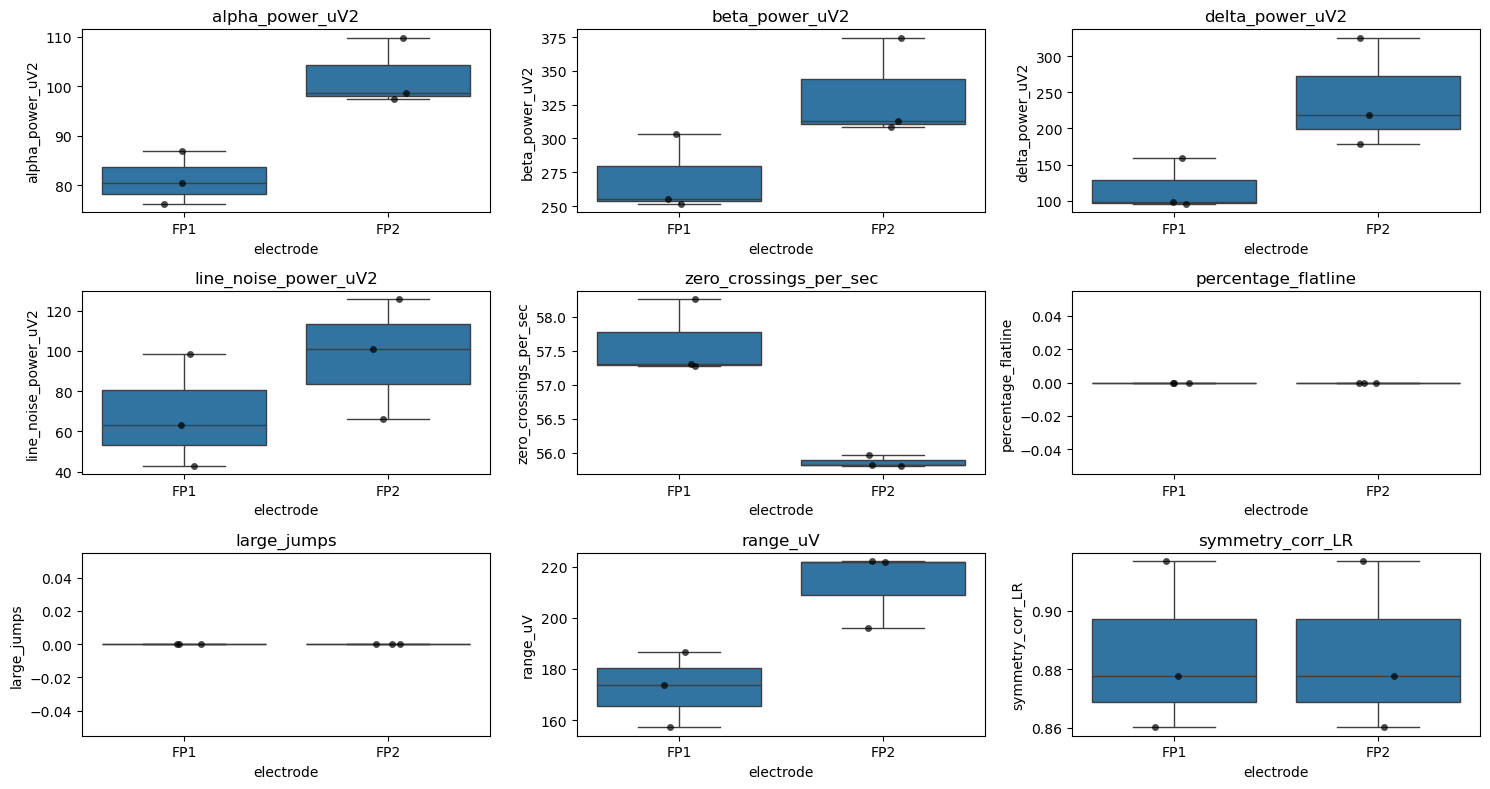

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_fp1 = pd.DataFrame(recordingsEOFP1)
df_fp1['electrode'] = 'FP1'

df_fp2 = pd.DataFrame(recordingsEOFP2)
df_fp2['electrode'] = 'FP2'


df = pd.concat([df_fp1, df_fp2], ignore_index=True)


metrics = ['alpha_power_uV2', 'beta_power_uV2', 'delta_power_uV2', 'line_noise_power_uV2',
           'zero_crossings_per_sec', 'percentage_flatline', 'large_jumps', 'range_uV', 'symmetry_corr_LR']

print("===stat ===")
for metric in metrics:
    print(f"\nMétrica: {metric}")
    stats = df.groupby('electrode')[metric].agg(['mean', 'median', 'std', 'min', 'max'])
    stats['IQR'] = df.groupby('electrode')[metric].quantile(0.75) - df.groupby('electrode')[metric].quantile(0.25)
    print(stats)

# Visualización: boxplot + stripplot
plt.figure(figsize=(15, 8))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df, x='electrode', y=metric)
    sns.stripplot(data=df, x='electrode', y=metric, color='black', alpha=0.7, jitter=True)
    plt.title(metric)
    plt.tight_layout()

plt.show()